In [1]:

from __future__ import print_function

In [13]:
from awips.dataaccess import DataAccessLayer
from awips.tables import vtec
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import ShapelyFeature,NaturalEarthFeature
from shapely.geometry import MultiPolygon,Polygon

from awips.dataaccess import DataAccessLayer
import matplotlib.pyplot as plt
from matplotlib import patheffects
import cartopy.crs as ccrs
import numpy as np
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import ShapelyFeature,NaturalEarthFeature
from shapely.geometry import Polygon
from shapely.ops import cascaded_union

def warning_color(phensig):
    return vtec[phensig]['color']

def make_map(bbox, projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(20,12),
            subplot_kw=dict(projection=projection))
    ax.set_extent(bbox)
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

Using 297 records
{'phensig': array([], dtype=float64)}


No handles with labels found to put in legend.


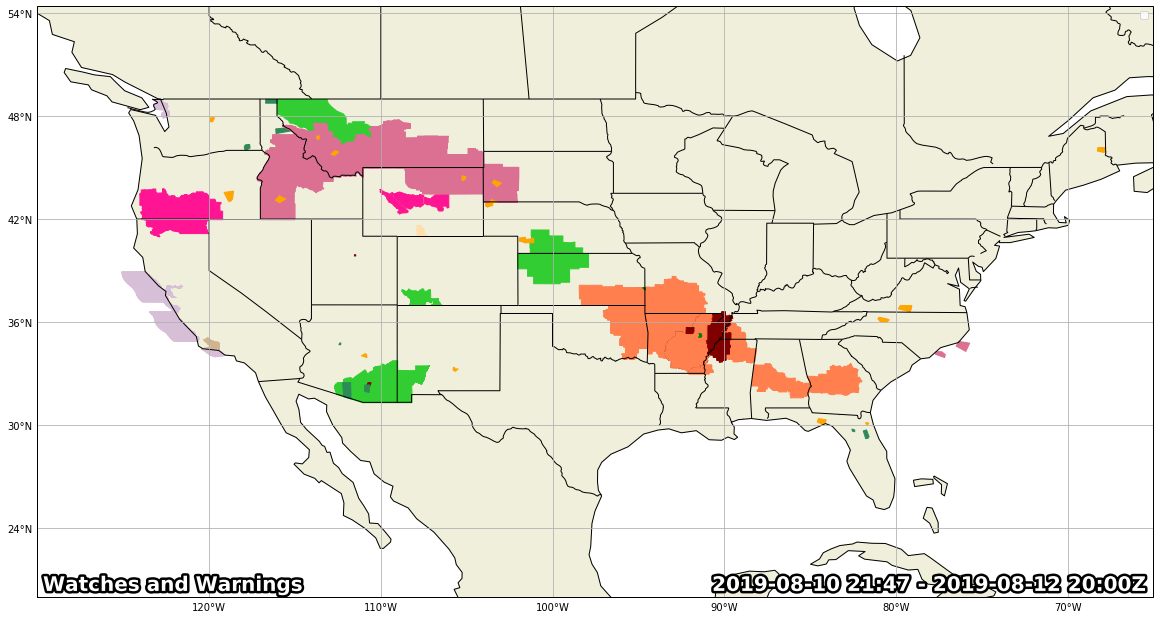

In [18]:
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest()
request.setDatatype("warning")
request.setParameters('phensig')
times = DataAccessLayer.getAvailableTimes(request)

# Get records for last 50 available times
response = DataAccessLayer.getGeometryData(request, times[-150:-1])
print("Using " + str(len(response)) + " records")

# Each record will have a numpy array the length of the number of "parameters"
# Default is 1 (request.setParameters('phensig'))
parameters = {}
for x in request.getParameters():
    parameters[x] = np.array([])
print(parameters)


bbox=[-130,-65,20,50]
fig, ax = make_map(bbox=bbox)

siteids=np.array([])
periods=np.array([])
reftimes=np.array([])

for ob in response:
    
    poly = ob.getGeometry()
    site = ob.getLocationName()
    pd   = ob.getDataTime().getValidPeriod()
    ref  = ob.getDataTime().getRefTime()

    #print(site)
    # do not plot if phensig is blank (SPS)
    if ob.getString('phensig'):
        
        phensigString = ob.getString('phensig')
        #print(phensigString)
        siteids = np.append(siteids,site)
        periods = np.append(periods,pd)
        reftimes = np.append(reftimes,ref)

        for parm in parameters:
            parameters[parm] = np.append(parameters[parm],ob.getString(parm))

        if poly.geom_type == 'MultiPolygon':
            geometries = np.array([])
            geometries = np.append(geometries,MultiPolygon(poly))
            geom_count = ", " + str(len(geometries)) +" geometries"
        else:
            geometries = np.array([])
            geometries = np.append(geometries,Polygon(poly))
            geom_count=""

        for geom in geometries:
            bounds = Polygon(geom)
            intersection = bounds.intersection
            geoms = (intersection(geom)
                 for geom in geometries
                 if bounds.intersects(geom))
    
        #print(vtec[phensigString]['hdln'] 
        #  + " (" + phensigString + ") issued at " + str(ref)
        #  + " ("+str(poly.geom_type) + geom_count + ")")
        
        color = warning_color(phensigString)
        shape_feature = ShapelyFeature(geoms,ccrs.PlateCarree(), 
                        facecolor=color, edgecolor=color)
        ax.add_feature(shape_feature)

ax.legend()
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
political_boundaries = cfeature.NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='black')
ax.add_feature(political_boundaries, edgecolor='black')


text_time = ax.text(.995, 0.01, 
            str(times[-150])[:-3]+" - "+str(times[-1])[:-3]+"Z",
            horizontalalignment='right', transform=ax.transAxes,
            color='white', fontsize=20, weight='bold',zorder=15)

text_time2 = ax.text(0.005, 0.01, 
            "Watches and Warnings",
            horizontalalignment='left', transform=ax.transAxes,
            color='white', fontsize=20, weight='bold',zorder=15)

outline_effect = [patheffects.withStroke(linewidth=5, foreground='black')]
text_time.set_path_effects(outline_effect)
text_time2.set_path_effects(outline_effect)


plt.savefig("/Users/chowdahead/Desktop/Watch_Warn_"+str(times[-150])[:10].replace("-","_")+".png",bbox_inches="tight")
#plt.show()

In [ ]:
phensigString

In [ ]:
from __future__ import print_function
from awips.dataaccess import DataAccessLayer
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import ShapelyFeature,NaturalEarthFeature
from shapely.geometry import Polygon
from shapely.ops import cascaded_union

# Standard map plot
def make_map(bbox, projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(12,12),
            subplot_kw=dict(projection=projection))
    ax.set_extent(bbox)
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax



![](https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/NWS_Weather_Forecast_Offices.svg/480px-NWS_Weather_Forecast_Offices.svg.png)

In [ ]:
# Server, Data Request Type, and Database Table
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest('maps')
request.addIdentifier('table', 'mapdata.county')
# Define a WFO ID for location
# tie this ID to the mapdata.county column "cwa" for filtering
request.setLocationNames('ILN')
request.addIdentifier('cwa', 'ILN')

# enable location filtering (inLocation)
# locationField is tied to the above cwa definition (BOU)
request.addIdentifier('geomField', 'the_geom')
request.addIdentifier('inLocation', 'true')
request.addIdentifier('locationField', 'cwa')

# This is essentially the same as "'"select count(*) from mapdata.cwa where cwa='BOU';" (=1)

# Get response and create dict of county geometries
response = DataAccessLayer.getGeometryData(request, [])
counties = np.array([])
for ob in response:
    counties = np.append(counties,ob.getGeometry())
print("Using " + str(len(counties)) + " county MultiPolygons")


%matplotlib inline
# All WFO counties merged to a single Polygon
merged_counties = cascaded_union(counties)
envelope = merged_counties.buffer(2)
boundaries=[merged_counties]

# Get bounds of this merged Polygon to use as buffered map extent
bounds = merged_counties.bounds
bbox=[bounds[0]-1,bounds[2]+1,bounds[1]-1.5,bounds[3]+1.5]


fig, ax = make_map(bbox=bbox)
# Plot political/state boundaries handled by Cartopy
political_boundaries = NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')
states = NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')
ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)

# Plot CWA counties
for i, geom in enumerate(counties):
    cbounds = Polygon(geom)
    intersection = cbounds.intersection
    geoms = (intersection(geom)
         for geom in counties
         if cbounds.intersects(geom))
    shape_feature = ShapelyFeature(geoms,ccrs.PlateCarree(), 
                        facecolor='none', linestyle="-",edgecolor='#86989B')
    ax.add_feature(shape_feature)

In [ ]:
import numpy.ma as ma
request = DataAccessLayer.newDataRequest()
request.setDatatype("topo")
request.addIdentifier("group", "/")
request.addIdentifier("dataset", "full")
request.setEnvelope(envelope)
gridData = DataAccessLayer.getGridData(request)
print(gridData)
print("Number of grid records: " + str(len(gridData)))
print("Sample grid data shape:\n" + str(gridData[0].getRawData().shape) + "\n")
print("Sample grid data:\n" + str(gridData[0].getRawData()) + "\n")

In [ ]:
# Plot CWA envelope
for i, geom in enumerate(boundaries):
    gbounds = Polygon(geom)
    intersection = gbounds.intersection
    geoms = (intersection(geom)
         for geom in boundaries
         if gbounds.intersects(geom))
    shape_feature = ShapelyFeature(geoms,ccrs.PlateCarree(), 
                        facecolor='none', linestyle="-",linewidth=3.,edgecolor='#cc5000')
    ax.add_feature(shape_feature)

fig

In [ ]:
#fig, ax = make_map(bbox=bbox)
grid=gridData[0]
topo=ma.masked_invalid(grid.getRawData()) 
lons, lats = grid.getLatLonCoords()
print(topo.min())
print(topo.max())

# Plot topography
cs = ax.contourf(lons, lats, topo, 80, cmap=plt.get_cmap('terrain'),alpha=0.1)
cbar = fig.colorbar(cs, extend='both', shrink=0.5, orientation='horizontal')
cbar.set_label("topography height in meters")
fig